In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
import scipy.stats as st

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

import suppression as s
import utils
import linear_model

In [4]:
gaba_fn = 'gaba_data.txt'
supp_fn = 'supp_data_individual_20170427.txt'

In [5]:
sdf = utils.load_psychophys(supp_fn)
gdf = utils.load_gaba(gaba_fn)

In [6]:
plot_dir = "plots/redo-201809"

## Analyze tasks separately (before subsetting to include common subjects)##

In [7]:
pp_subjs = np.unique(sdf.Subject)
n_pp_subjs = len(pp_subjs)
gaba_subjs = np.unique(gdf.subjName)
n_gaba_subjs = len(gaba_subjs)
print(f"Psychophysics subjects (n={n_pp_subjs}):\n", pp_subjs)
print(f"GABA subjects (n={n_gaba_subjs}):\n", gaba_subjs)

Psychophysics subjects (n=37):
 ['ah' 'ai' 'am' 'ap' 'bi' 'bo' 'cl' 'cr' 'ct' 'dl' 'ds' 'eg' 'ei' 'em' 'es'
 'gd' 'gm' 'gw' 'jd' 'jv' 'ke' 'kw' 'li' 'ls' 'mg' 'mk' 'ms' 'mv' 'nl' 'nn'
 'rn' 'sd' 'se' 'tj' 'tm' 'tt' 'yl']
GABA subjects (n=31):
 ['ac' 'ai' 'am' 'as' 'bi' 'ch' 'cr' 'cs' 'ct' 'dl' 'ei' 'em' 'es' 'gd' 'gm'
 'jd' 'jm' 'jv' 'ks' 'kw' 'li' 'ls' 'mg' 'mk' 'ms' 'nl' 'ps' 'rn' 'sd' 'tt'
 'yl']


# GABA only analyses

### GABA t-test, CON v AMB

In [8]:
pop_group = gdf.groupby("Population")
pop_group.describe()

GABA                                                           
           count      mean       std    min     25%     50%      75%    max
Population                                                                 
Amblyope    16.0  0.202312  0.013385  0.179  0.1925  0.2025  0.21125  0.227
Control     15.0  0.206333  0.016482  0.173  0.1925  0.2110  0.21650  0.228

In [9]:
gaba_per_group = [col for col_name, col in pop_group['GABA']]
(tstat, pval) = st.ttest_ind(*gaba_per_group)
print(tstat, pval)

-0.747810754413 0.460595837907


** Thus we find no significant difference in GABA levels between CON and AMB. **

### GABA violin plot, all subjects

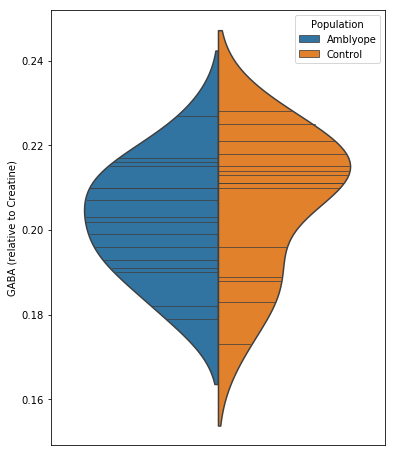

In [10]:
with s.PdfPages(f"{plot_dir}/gaba_diffs_n{n_gaba_subjs}.pdf") as pdf:
    fig = plt.figure(figsize=(6,8))  # create a figure object
    ax = fig.add_subplot(1, 1, 1)
    ax = sns.violinplot(y='GABA',x='Presentation',hue='Population',data=gdf,split=True,inner='stick',ax=ax)
    ax.xaxis.set_visible(False)
    ax.set_ylabel("GABA (relative to Creatine)")
    plt.show(ax.figure)
    pdf.savefig(ax.figure)
    plt.close(ax.figure)
    plt.close('all')

# Select one psychophysical task's data #

In [11]:
task = 'OS'
sdf = sdf[sdf['Task']==task]

In [12]:
df_to_model = sdf.copy() # make a deep copy

In [13]:
n_pp_subjs_thistask = len(np.unique(df_to_model.Subject))
n_amb_subjs_thistask = len(np.unique((df_to_model[df_to_model['Population']=='Amblyope'])['Subject']))
print(f"There are {n_pp_subjs_thistask} subjects for Task {task}, of which {n_amb_subjs_thistask} are Amblyopes.")

There are 36 subjects for Task OS, of which 13 are Amblyopes.


# Modeling

### Begin grouping data into conditions to model Subject's ThreshElev as a function of logRelContrast #

In [14]:
pp_gvars = ['Task','Orientation','Presentation','Population','Subject','Eye','Trace'] # One condition
pp_gvars_base = pp_gvars + ['BaselineThresh']

### Pick an xvalue (RelMaskContrast) to evaluate models at

2018-09-24: Abandoning Eunice's binning. Instead, try to figure out a good RelMaskContrast programatically.
 * Just looking at it (cell below), i'd say somewhere between 5 and 10 -- probably 6 (for SS) and 10 (for OS)

In [15]:
df_to_model.groupby([var for var in pp_gvars if var not in ["Subject"]])[["RelMaskContrast"]].describe(percentiles=[.25, .5, .6, .75])

RelMaskContrast  \
                                                                    count   
Task Orientation Presentation Population Eye Trace                          
OS   Cross       nDicho       Amblyope   De  Amblyope-De             51.0   
                                         Nde Amblyope-Nde            51.0   
                              Control    De  Control-De              51.0   
                                         Nde Control-Nde             91.0   
                 nMono        Amblyope   De  Amblyope-De             51.0   
                                         Nde Amblyope-Nde            51.0   
                              Control    De  Control-De              51.0   
                                         Nde Control-Nde             91.0   
     Iso         nDicho       Amblyope   De  Amblyope-De             50.0   
                                         Nde Amblyope-Nde            46.0   
                              Control    De  Control-De              51.0   
                                         Nde Control-Nde             88.0   
                 nMono        Amblyope   De  Amblyope-De             50.0   
                                         Nde Amblyope-Nde            50.0   
                              Control    De  Control-De              51.0   
                                         Nde Control-Nde             89.0   

                                                                      \
                                                                mean   
Task Orientation Presentation Population Eye Trace                     
OS   Cross       nDicho       Amblyope   De  Amblyope-De    9.989902   
                                         Nde Amblyope-Nde  13.507824   
                              Control    De  Control-De    13.208941   
                                         Nde Control-Nde   14.370659   
                 nMono        Amblyope   De  Amblyope-De   13.507824   
                                         Nde Amblyope-Nde   9.989902   
                              Control    De  Control-De    13.260588   
                                         Nde Control-Nde   14.341714   
     Iso         nDicho       Amblyope   De  Amblyope-De    9.499340   
                                         Nde Amblyope-Nde  11.506543   
                              Control    De  Control-De    13.208941   
                                         Nde Control-Nde   13.177841   
                 nMono        Amblyope   De  Amblyope-De   13.158600   
                                         Nde Amblyope-Nde   9.499340   
                              Control    De  Control-De    13.260588   
                                         Nde Control-Nde   13.422315   

                                                                             \
                                                                 std    min   
Task Orientation Presentation Population Eye Trace                            
OS   Cross       nDicho       Amblyope   De  Amblyope-De    8.360486  0.697   
                                         Nde Amblyope-Nde  10.098339  2.874   
                              Control    De  Control-De     8.957629  2.469   
                                         Nde Control-Nde   10.027643  2.039   
                 nMono        Amblyope   De  Amblyope-De   10.098339  2.874   
                                         Nde Amblyope-Nde   8.360486  0.697   
                              Control    De  Control-De     9.316148  2.039   
                                         Nde Control-Nde    9.847820  2.469   
     Iso         nDicho       Amblyope   De  Amblyope-De    7.668151  0.697   
                                         Nde Amblyope-Nde   7.812275  2.874   
                              Control    De  Control-De     8.957629  2.469   
                                         Nde Control-Nde    8.945252  2.039   
                 nMono        Amblyope  

In [16]:
xval_to_predict = {'SS': 6, 'OS': 10}

In [17]:
df_to_model['RelMCToPred'] = xval_to_predict[task]

In [18]:
groups = df_to_model.groupby(pp_gvars) 

### Linear model (defined in linear_model.py, uses lmfit)###

In [19]:
# initialize parameters
lm_params = linear_model.parameters()
preds_lm = groups.apply(utils.model_threshold, linear_model.err, linear_model.thresh, lm_params, ret='preds')

AttributeError: module 'utils' has no attribute 'model_threshold'

### Linear model, this time using statsmodels -- use to verify previous implementation was correct

In [20]:
df_to_model.columns

Index(['Subject', 'Task', 'Presentation', 'Orientation', 'Eye', 'Population',
       'MaskContrast', 'ThreshElev', 'ThreshElev_SE', 'RelMaskContrast',
       'Trace', 'BaselineThresh', 'BinCenterRelMaskContrast', 'BinNumber',
       'logThreshElev', 'logRelMaskContrast', 'RelMCToPred'],
      dtype='object')

In [21]:
import statsmodels.formula.api as sm

for gv, g in groups:
    result = sm.ols(formula="ThreshElev ~ RelMaskContrast", data=g).fit()
    result = linear_fit(df, x, y)
    preds = pd.Series(result.predict(), index=df[x], name='ThreshPred')
    return preds
    print(gv, result.params, sep="\n")

('OS', 'Cross', 'nDicho', 'Amblyope', 'ah', 'De', 'Amblyope-De')
Intercept          1.663579
RelMaskContrast    0.010934
dtype: float64
('OS', 'Cross', 'nDicho', 'Amblyope', 'ah', 'Nde', 'Amblyope-Nde')
Intercept          2.168488
RelMaskContrast    0.109311
dtype: float64
('OS', 'Cross', 'nDicho', 'Amblyope', 'am', 'De', 'Amblyope-De')
Intercept          0.939042
RelMaskContrast    0.013325
dtype: float64
('OS', 'Cross', 'nDicho', 'Amblyope', 'am', 'Nde', 'Amblyope-Nde')
Intercept          1.049379
RelMaskContrast    0.017715
dtype: float64
('OS', 'Cross', 'nDicho', 'Amblyope', 'bi', 'De', 'Amblyope-De')
Intercept          0.910471
RelMaskContrast    0.022884
dtype: float64
('OS', 'Cross', 'nDicho', 'Amblyope', 'bi', 'Nde', 'Amblyope-Nde')
Intercept          5.436084
RelMaskContrast    0.792939
dtype: float64
('OS', 'Cross', 'nDicho', 'Amblyope', 'cl', 'De', 'Amblyope-De')
Intercept          0.743895
RelMaskContrast    0.044875
dtype: float64
('OS', 'Cross', 'nDicho', 'Amblyope', 'cl'

('OS', 'Cross', 'nMono', 'Amblyope', 'sd', 'Nde', 'Amblyope-Nde')
Intercept          1.025604
RelMaskContrast   -0.097892
dtype: float64
('OS', 'Cross', 'nMono', 'Amblyope', 'tt', 'De', 'Amblyope-De')
Intercept          0.466437
RelMaskContrast    0.041436
dtype: float64
('OS', 'Cross', 'nMono', 'Amblyope', 'tt', 'Nde', 'Amblyope-Nde')
Intercept          0.759614
RelMaskContrast    0.015099
dtype: float64
('OS', 'Cross', 'nMono', 'Control', 'ai', 'De', 'Control-De')
Intercept          0.406470
RelMaskContrast    0.053249
dtype: float64
('OS', 'Cross', 'nMono', 'Control', 'ai', 'Nde', 'Control-Nde')
Intercept          1.198593
RelMaskContrast    0.007915
dtype: float64
('OS', 'Cross', 'nMono', 'Control', 'ap', 'Nde', 'Control-Nde')
Intercept          0.810950
RelMaskContrast    0.033893
dtype: float64
('OS', 'Cross', 'nMono', 'Control', 'bo', 'Nde', 'Control-Nde')
Intercept          1.010054
RelMaskContrast    0.028852
dtype: float64
('OS', 'Cross', 'nMono', 'Control', 'cr', 'Nde', 'Con

dtype: float64
('OS', 'Iso', 'nDicho', 'Control', 'gm', 'Nde', 'Control-Nde')
Intercept          1.807041
RelMaskContrast    0.810611
dtype: float64
('OS', 'Iso', 'nDicho', 'Control', 'gw', 'Nde', 'Control-Nde')
Intercept          5.055253
RelMaskContrast    0.865411
dtype: float64
('OS', 'Iso', 'nDicho', 'Control', 'jd', 'De', 'Control-De')
Intercept         -2.424082
RelMaskContrast    1.294680
dtype: float64
('OS', 'Iso', 'nDicho', 'Control', 'jd', 'Nde', 'Control-Nde')
Intercept         -0.254912
RelMaskContrast    1.006515
dtype: float64
('OS', 'Iso', 'nDicho', 'Control', 'ke', 'Nde', 'Control-Nde')
Intercept         -3.139910
RelMaskContrast    1.314523
dtype: float64
('OS', 'Iso', 'nDicho', 'Control', 'kw', 'De', 'Control-De')
Intercept         -1.259062
RelMaskContrast    0.928764
dtype: float64
('OS', 'Iso', 'nDicho', 'Control', 'kw', 'Nde', 'Control-Nde')
Intercept          0.128384
RelMaskContrast    0.996790
dtype: float64
('OS', 'Iso', 'nDicho', 'Control', 'ls', 'De', 'Con

('OS', 'Iso', 'nMono', 'Control', 'ls', 'Nde', 'Control-Nde')
Intercept          0.233101
RelMaskContrast    0.203778
dtype: float64
('OS', 'Iso', 'nMono', 'Control', 'mk', 'De', 'Control-De')
Intercept          1.880409
RelMaskContrast    0.100020
dtype: float64
('OS', 'Iso', 'nMono', 'Control', 'mk', 'Nde', 'Control-Nde')
Intercept          1.572322
RelMaskContrast    0.151181
dtype: float64
('OS', 'Iso', 'nMono', 'Control', 'ms', 'De', 'Control-De')
Intercept          1.146664
RelMaskContrast    0.034580
dtype: float64
('OS', 'Iso', 'nMono', 'Control', 'ms', 'Nde', 'Control-Nde')
Intercept          0.979350
RelMaskContrast    0.080861
dtype: float64
('OS', 'Iso', 'nMono', 'Control', 'nl', 'De', 'Control-De')
Intercept          0.683097
RelMaskContrast    0.043300
dtype: float64
('OS', 'Iso', 'nMono', 'Control', 'nl', 'Nde', 'Control-Nde')
Intercept          0.620627
RelMaskContrast    0.075235
dtype: float64
('OS', 'Iso', 'nMono', 'Control', 'nn', 'Nde', 'Control-Nde')
Intercept    

** Note on column names: **
 * RelMaskContrast is the presented MaskContrast (absolute, in C%) divided by the subject's BaselineThresh
 * ThreshElev is the *observed* threshold elevation at that RelMaskContrast
 * ThreshPred is the *model's predicted* threshold elevation at that RelMaskContrast
 * RelMCToPred is the RelMaskContrast that is the center of the bin with the biggest NDE/DE difference (BinNumberToPred)

In [22]:
preds_lm.columns

NameError: name 'preds_lm' is not defined

### Plot the regression lines 

In [24]:
s.group_facet_plots(preds_lm, s.subject_fit_plot,
                    f"{plot_dir}/{task}_regressions_combinedplots_n{n_pp_subjs_thistask}_TOP.pdf",
                    ['Task','Orientation','Presentation'], #each combo of this gets its own page
                    row='Population',col='Eye',# facet rows and columns
                    x="RelMaskContrast", y="ThreshElev", # x, y
                    hue="Subject",yerr='ThreshElev_SE',fmt_obs='.',fmt_pred='x:',Ycol="ThreshPred") 

NameError: name 'preds_lm' is not defined

In [ ]:
s.group_facet_plots(preds_lm, s.population_fit_plot,
                    f"{plot_dir}/{task}_regressions_combinedplots_n{n_pp_subjs_thistask}_TO.pdf",
                    ['Task','Orientation'], #each combo of this gets its own page
                    row='Presentation',col='Eye',# facet rows and columns
                    x="RelMaskContrast", y="ThreshElev", # x, y
                    hue="Population",yerr='ThreshElev_SE',fmt_obs='.',fmt_pred='x:',Ycol="ThreshPred") 

### Conclusions from these regression plots (_TO):
 * SS: looks fine, esp with new binning (IMO).
 * OS: one or two subjects really messes up the axes. One bc of a huge error bar on their observed ThreshElev, one but v low predicted ThreshElev by model; exclude? Both are controls so part of the larger group.
   * This only happens in Iso-orientation, which is different from Cross in substantial ways. What does that indicate?

### Model the data again, but this time return parameters, not predictions ###

In [ ]:
print(pp_gvars_base)
pp_gvars_base_mcpred = pp_gvars_base + ['RelMCToPred']
groups_with_baseline_mcpred = df_to_model.groupby(pp_gvars_base_mcpred)

In [ ]:
pfit = groups_with_baseline_mcpred.apply(utils.model_threshold, linear_model.err, linear_model.thresh, lm_params, ret='weights').reset_index()

In [ ]:
pfit.head()

In [ ]:
pfit.groupby(["Orientation", "Presentation", "Population", "Eye", "RelMCToPred"]).describe()

In [ ]:
pfit['ThreshPredCritical'] = pfit['y_int'] + pfit['slope'] * pfit['RelMCToPred']
pfit['ThreshPredCriticalUnnorm'] = pfit['ThreshPredCritical'] * pfit['BaselineThresh']

### Depth of suppression measures ("how far from ThreshElev=1?")

In [ ]:
pfit['DepthOfSuppressionPred'] = (-1) + pfit['ThreshPredCritical']

In [ ]:
# melt the result of the modeling into long format for plotting
pfit_all_ppsub = pd.melt(pfit, id_vars=pp_gvars, var_name='measure')
pfit_all_ppsub.head()

## Subset to include only (GABA and psychophyics) subjects

In [ ]:
gaba_and_pp_subjs = list(np.intersect1d(pp_subjs, gaba_subjs))
n_gaba_and_pp_subjs = len(gaba_and_pp_subjs)

In [ ]:
sdf = sdf[sdf.Subject.isin(gaba_and_pp_subjs)] # only subjects who did _the current_ pp task and GABA
gaba_and_pp_subjs_thistask = np.unique(sdf.Subject)
n_gaba_and_pp_subjs_thistask = len(gaba_and_pp_subjs_thistask)
print(f"Of the {n_gaba_and_pp_subjs} subjects with both GABA and psychophysics data, {n_gaba_and_pp_subjs_thistask} have both for task {task}.")

In [ ]:
gdf = gdf[gdf.subjName.isin(sdf.Subject)] # only subjects who did both tasks
print(f"Of the {len(gdf)} subjects with GABA and {task} data, {len(gdf[gdf.Population=='Amblyope'])} are Amblyopes.")
n_this_task = len(gdf)

## Combine Psychophysics and GABA below

In [ ]:
#Grab the GABA measure for each subject and append it to each observation for easy plotting
comb = pfit_all_ppsub.join(gdf.set_index(['subjName'])['GABA'], on=['Subject'])
print(len(comb))

#subset to include only those subjects with GABA data
comb_gabappsub = comb[~np.isnan(comb['GABA'])]
print(len(comb_gabappsub), f"{len(np.unique(comb_gabappsub.Subject))} subjects")

In [ ]:
comb_gabappsub.head(n=10)

In [ ]:
np.unique(comb_gabappsub.measure)

In [ ]:
#graphs!
with s.PdfPages(f"{plot_dir}/gaba_vs_{task}_n{n_this_task}_linear.pdf") as pdf:
    plot_groups = comb_gabappsub.groupby(['Task','Orientation','measure'])
    for gv, gr in plot_groups:
        print(gv, np.all(np.isnan(gr['value'])))
        #print(gr.columns)
        #if gv[0]=='SS' and gv[1]=='Cross': continue
        g2 = s.gaba_vs_psychophys_plot_2line(gv, gr)
        pdf.savefig(g2.fig)
        #g4 = s.gaba_vs_psychophys_plot_4line(gv, gr)
        #pdf.savefig(g4.fig)
        
    plt.close('all')

### Conclusions from the graphs we just generated
#### SS, but using old bins initially; updated with new bins info:
 * BaselineThresh
    * There is a negative relationship between GABA and BaselineThresh for both eyes, both populations, both surround conditions. This is an interesting finding in itself...
      * (nDicho and nMono are identical since this is baseline thresh, ie just one eye)
      * new bins: this remains true.
 * DepthOfSuppression
    * In SS/Cross/Dicho, more GABA = less suppression of NDE, but = more suppression of DE. This is especially true of Amblyopes, while in Controls the effect is weak/insignificant.
      * new bins: this remains true, and the positive slope of GABA vs suppression for the DE is higher in nMono than nDicho -- what does this mean?
    * In SS/Iso/Dicho, more GABA = less suppression of NDE, = more suppression of DE. Effect is very strong for Amblyopes and absent for other conditions(AMB/Mono and all Controls)
      * new bins: still true
 * Critical Bin Center (RelMCToPred)
    * In SS/Cross/Dicho the NDE has a higher (numerically, in multiples of baseline) RelMCToPred for both AMB and CON
    * But in SS/Cross/Mono it's the reverse, DE has higher RelMCToPred for both populations
    * new bins: this measure is rendered obsolete since I handpicked an x-val
 * ThreshPredCritical
    * For both Cross and Iso, Dicho/AMB shows biggest difference b/t NDE and DE in predicted threshold elevation. Other conditions show little to no difference.
    * new bins: now seeing this effect in AMB/nMono, similar to DepthofSuppression
 * ThreshPredCriticalUnnorm
    * When we normalize by each eye's baseline, this effect is still present.
    * new bins: still true, and unlike baseline-normalized ThreshPredCritical, effect not present in nMono (ie same pattern as with the old bins)
 * Linear model slope
    * AMB/Dicho shows biggest difference between trends in each eye for both presentation conditions. more GABA ~ lower slope of the line for NDE, while DE is basically flat.
    * new bins: nMono shows effect too, AMB look v different than controls, esp in Dicho.
 * Linear model y-int
    * AMB/Dicho has opposite GABA vs y-int slopes for both Iso and Cross, but the distributions overlap for all conditions and populations, so this is a weak finding.
    * new bins: same
    
#### OS, new bins
 * BaselineThresh
   * no strong trends vs GABA for either Iso or Cross.
 * DepthOfSuppression
   * Cross: positive slope for NDE in all conditions, much stronger in Dicho. DE flat in all, p much.
   * Iso: negative slope for NDE in AMB/Dicho. Positive/flat slopes in other conditions, and for De slopes 
 * Critical Bin Center (RelMCToPred): handpicked
 * ThreshPredCritical
   * Cross: NDE positive, DE flat-ish, least CI overlap in AMB/Dicho
   * Iso: everything overlaps a lot. least so in AMB/Dicho (NDE vs DE)
 * ThreshPredCriticalUnnorm
   * Cross: Same as normalized, but bigger diff/less overlap in AMB/Dicho than normalized.
   * Iso: everything overlaps a lot. least so in AMB/Dicho
 * Linear model slope
   * Cross: basically all flat, except nMono/AMB/NDE? Weak/nonexistent/CI overlappy tho.
   * Iso: Trending opposite DE/NDE but all overlap a lot
 * Linear model y-int
   * Cross: NDE slopes positive (for both AMB and CON, but higher magnitude for AMB), least overlap in AMB/Dicho
   * NDE vs DE trend similar in Dicho but opposite in Mono (for both Con and AMB), but lots of overlap


### Combine measures across the two eyes

 * Does it make sense to combine all measures across both eyes (i.e. by subtracting?) For example, ThreshElev is in units of baseline, and the baseline varies by eye. So perhaps only a few measures should be combined -- say, slope/yint, ThreshPredCriticalUnnorm. 

In [ ]:
#subset to include only these measures:
# - baseline threshold
# - unnormalized predicted threshold elevation at critical bin center
# - slope of ThreshElev ~ RelMaskContrast line
# - y-int of this line
measures = comb_gabappsub[comb_gabappsub["measure"].isin(["BaselineThresh","ThreshPredCritical","slope","y_int"])]
#print(len(comb_all_ppsub))

In [ ]:
np.unique(measures.measure)

In [ ]:
paired_obs = measures.groupby(['Task', 'Orientation', 'Population', 'Presentation', 'Subject', 'measure'])

def get_eyediff_value(g):
    if len(g)==2: # this will exclude paired observations where there was no data for one eye
        value_diff = g[g['Eye']=='Nde'].value.iat[0] - g[g['Eye']=='De'].value.iat[0]
        #print(g.name, value_diff)
        return pd.Series([value_diff], ['Nde-De'])

In [ ]:
obs_diff = paired_obs.apply(get_eyediff_value).reset_index()

In [ ]:
obs_diff.head(n=6)

In [ ]:
comb_botheyes = obs_diff.join(gdf.set_index(['subjName'])['GABA'], on=['Subject'])

In [ ]:
comb_botheyes.head()

In [ ]:
print(len(np.unique(comb_botheyes.Subject)))

In [ ]:
#graphs!
with s.PdfPages(f"{plot_dir}/gaba_vs_{task}_combeyes_n{n_this_task}.pdf") as pdf:
    plot_groups = comb_botheyes.groupby(['Task','Orientation','measure'])
    for gv, gr in plot_groups:
        print(gv)
        g2 = s.gaba_vs_psychophys_plot_2line_2eye(gv, gr)
        pdf.savefig(g2.fig)
        
    plt.close('all')

In [ ]:
# more graphs for presentation!
with s.PdfPages(f"{plot_dir}/gaba_vs_{task}_combeyes_n{n_this_task}_condensed.pdf") as pdf:
    plot_groups = comb_botheyes.groupby(['Task','measure'])
    for gv, gr in plot_groups:
        print(gv)
        if gv[-1] not in ["BaselineThresh", "RelMCToPred"]: # use this line to exclude measures we don't want
            g2 = s.gaba_vs_psychophys_plot_2line_2eye(gv, gr, row="Orientation", size=8, aspect=1.2)
            #print(g2.axes)
            pdf.savefig(g2.fig)
        
    plt.close('all')

### Conclusions from Interocular suppression graphs
#### SS, new bins
 * Interocular difference measures all seem to get back to “the two eyes of amblyopes are more different than the two eyes of controls, and the magnitude of this difference is inversely related to GABA).
   * This is interesting and we want to present it, right?
#### OS, new bins:
 * Some strong effects in y-int Iso in both Dicho and esp. Mono. Cross is a wash
 * Other measures look fairly similar?

### Orientation-selective suppression can go here

 * We should start off by doing each eye separately, right? So, starting from comb_gabappsub df.
 * Or if we started from the combined-eye data generated above, use measures df.

In [ ]:
oss_gvars = ["Task", "Presentation", "Population", "Subject", "Eye", "Trace", "measure", "GABA"]

In [ ]:
def calculate_orientation_selective_suppression(df, **kwargs):
    #print(df[['Orientation', 'value']])
    iso_cross_oss_ratio = df[df.Orientation=='Iso']['value'].iloc[0]/df[df.Orientation=='Cross']['value'].iloc[0]
    print(f"Iso/Cross ratio: {iso_cross_oss_ratio}")
    return pd.Series(iso_cross_oss_ratio, ['value'])
    #print(df[df['Orientation'=='Cross']]) #/df[df['Orientation'=='Cross']]['value']

In [ ]:
oss_df = comb_gabappsub.groupby(oss_gvars).apply(calculate_orientation_selective_suppression).reset_index()

In [ ]:
oss_df.head()

In [ ]:
oss_df.columns

In [ ]:
#graphs!
with s.PdfPages(f"{plot_dir}/gaba_vs_{task}_oss_n{n_this_task}.pdf") as pdf:
    plot_groups = oss_df.groupby(['Task','measure'])
    for gv, gr in plot_groups:
        if gv[-1] not in ["BaselineThresh", "RelMCToPred"]:
            print(gv, np.all(np.isnan(gr['value'])))
            g2 = s.gaba_vs_oss_plot_2line(gv, gr)
            pdf.savefig(g2.fig)
        
    plt.close('all')

### Conclusions from these graphs:
#### SS new and old bins, they're all the same
 * The two eyes seem to not be that different in their Iso/Cross ratios of the various measures.

#### OS new bins
 * NDE vs DE Iso/Cross ratios often trend different relative to GABA, but CIs overlap.